# Overview

This week is about tying everything together. We try to combine our work on networks plus our work on language in order to understand and analyze human behavior. We'll be working on a cool dataset of humans playing a game on (a special version of) wikipedia called "wikispeedia" (the game is now defunct and wikispeedia.org is a page about GPS coordinates of speed-traps, so you can't play it). 

Here's how the game worked:

> In the game, users are asked to navigate from a given _source_ article (e.g. https://en.wikipedia.org/wiki/Gold_dollar) to a given _target_ article (e.g. https://en.wikipedia.org/wiki/Ronald_Reagan), **by only clicking Wikipedia links**. A condensed version of Wikipedia (4,604 articles) is used. 

So this dataset contains **human navigation paths** (clicking from page to page to find a target) and today we will work on this dataset to see if we can use our skills to understand how human navigation works. We will think about the following questions.

* Path lengths
* Betweenness from the human perspective
* What characterizes human paths?

Since we're putting our existing skills to use, there is very little reading today - it's all about exploring the dataset. Let's get started.

## Download the dataset

The first thing we're going to do is download the dataset. Today everything related to data is nice, clean, and easy to work with (Yay). You can get the dataset [here](https://snap.stanford.edu/data/wikispeedia.html). You will need to get 

* The list of wiki articles
* The network connections
* The navigation paths
* Plaintext of the wiki articles

In [2]:
import cStringIO
from collections import Counter
from __future__ import division
from itertools import izip
import math
from matplotlib import pyplot as plt
import networkx as nx
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import operator
import os
import pandas as pd
import pprint
import scipy.stats as stats
import tarfile
import urllib

# IPython specifics
%matplotlib inline

# common directories to save dataset
directory = 'wikispeedia'
if not os.path.exists(directory):
    os.makedirs(directory)
text_file = 'texts.tar.gz'
network_file = 'network.tar.gz'

# download data if necessary ()e.g.: stopwords
nltk.download()

# specify nltk data dir, otherwise LookupError error
nltk.data.path.append(os.getcwd() + '/../nltk_data')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


## Fetch data and buil network

In [3]:
# get archives and save to disk
urllib.urlretrieve('https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz', 
                   '{0}/{1}'.format(directory, text_file))
urllib.urlretrieve('https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_plaintext.tar.gz', 
                   '{0}/{1}'.format(directory, network_file))

('wikispeedia/network.tar.gz',
 <httplib.HTTPMessage instance at 0x7fd5260b0d88>)

In [4]:
# extract archives
tar_t = tarfile.open('{0}/{1}'.format(directory, text_file))
tar_t.extractall(directory)
tar_t.close()
tar_p = tarfile.open('{0}/{1}'.format(directory, network_file))
tar_p.extractall(directory)
tar_p.close()

In [3]:
# file location articles
net_dir = 'wikispeedia_paths-and-graph'
articles = '{0}/{1}/articles.tsv'.format(directory, net_dir)

# dataframe of wiki articles, skip initial header rows
wiki_articles = pd.read_csv(articles, sep='\t', names=['article'], skiprows=xrange(0, 12))
print wiki_articles.head()

                            article
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1                        %C3%85land
2                %C3%89douard_Manet
3                         %C3%89ire
4        %C3%93engus_I_of_the_Picts 4604


In [4]:
# create one node per article
w_graph = nx.DiGraph()
w_graph.add_nodes_from(wiki_articles['article'].tolist()) 

In [7]:
# file location links
links = '{0}/{1}/links.tsv'.format(directory, net_dir)

# dataframe of network connections, skip initial header rows
wiki_links = pd.read_csv(links, sep='\t', names=['linkSource', 'linkTarget'], skiprows=xrange(0, 12))
print wiki_links.head()

                         linkSource      linkTarget
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in            Bede
1  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata
3  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   Great_Britain
4  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland 119882


In [11]:
# create list of tuples with source and target as column
link_list = zip(wiki_links['linkSource'], wiki_links['linkTarget'])

# add as links to the network
w_graph.add_edges_from(link_list)

In [12]:
# file location paths
paths = '{0}/{1}/paths_finished.tsv'.format(directory, net_dir)

# dataframe of navigation paths, skip initial header rows
header = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
human_paths = pd.read_csv(paths, sep='\t', names=header, skiprows=xrange(0, 16))
print human_paths.head()

    hashedIpAddress   timestamp  durationInSec  \
0  6a3701d319fc3754  1297740409            166   
1  3824310e536af032  1344753412             88   
2  415612e93584d30e  1349298640            138   
3  64dd5cd342e3780c  1265613925             37   
4  015245d773376aab  1366730828            175   

                                                path  rating  
0  14th_century;15th_century;16th_century;Pacific...     NaN  
1  14th_century;Europe;Africa;Atlantic_slave_trad...     3.0  
2  14th_century;Niger;Nigeria;British_Empire;Slav...     NaN  
3     14th_century;Renaissance;Ancient_Greece;Greece     NaN  
4  14th_century;Italy;Roman_Catholic_Church;HIV;R...     3.0   51318


In [13]:
# wiki plaintext folder
plaintext_dir = '{0}/plaintext_articles'.format(directory)

wiki_plaintexts = dict()
# for every file
for f in os.listdir(plaintext_dir):
    with open('{0}/{1}'.format(plaintext_dir, f), 'rb') as fh:
        content = fh.read()
        # save key with name of text (node) and content of file
        wiki_plaintexts[f.split('.txt')[0]] = content
        
print "sample text of 14th_century article:\n", wiki_plaintexts['14th_century'][:800]

sample text of 14th_century article:
   #copyright

14th century

2007 Schools Wikipedia Selection. Related subjects: General history

   Millennium: 1st millennium - 2nd millennium - 3rd millennium
   Centuries:         13th century - 14th century - 15th century
     Decades: 1300s 1310s 1320s 1330s 1340s 1350s 1360s 1370s 1380s 1390s
   This 14th-century statue from south India depicts the gods Shiva (on
   the left) and Uma (on the right). It is housed in the Smithsonian
   Institution in Washington, D.C..
   Enlarge
   This 14th-century statue from south India depicts the gods Shiva (on
   the left) and Uma (on the right). It is housed in the Smithsonian
   Institution in Washington, D.C..

   As a means of recording the passage of time, the 14th century was that
   century which lasted from 1301 to 1400.

Events

     * 


# Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths. 

_Exercises_
> * For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/shortest-path.png)

In [18]:
# create list of source and target pairs
path_list = human_paths['path'].tolist()

In [19]:
# isolated nodes in paths are not wanted
isolated_nodes = nx.isolates(w_graph)

In [22]:
p_compare = dict()
for path in path_list:
    # list of each node visited
    n = path.split(';')
    # elimate back choice as a visited node
    nodes_visited = [x for x in n if x != '<']
    # first element source, last target
    source = nodes_visited[0]
    target = nodes_visited[-1]
    # exclude isolated nodes
    if source in isolated_nodes or target in isolated_nodes:
        print "WARN, unclean data: source or target are in isolated path:", path
        continue
    # exclude node
    if source == target:
        print "WARN, unclean data: source and target are the same:", path
        continue    
        
    # add paths to dict with key: tuple source, target and value: list of lengths    
    length = len(nodes_visited)
    # create new key if not exists
    if (source, target) not in p_compare:
        p_compare[(source, target)] = {
            'human_shortest_path': [length],
            'human_shortest_nodes': nodes_visited
        };
    else:
        key = (source, target)
        current_val = p_compare[key]['human_shortest_path']
        # extend the list with lengths
        p_compare[key]['human_shortest_path'] = current_val + [length]
        # save eventually new shortest path nodes
        if len(p_compare[key]['human_shortest_nodes']) < length:
            p_compare[key]['human_shortest_nodes'] = nodes_visited

# show small excerpt of 14th_century (first in human_paths)
print "\n"
for p in p_compare:
    if p[0] == '14th_century':
        print p, p_compare[p], "\n"

WARN, unclean data: source or target are in isolated path: Bird;Wikipedia_Text_of_the_GNU_Free_Documentation_License
WARN, unclean data: source and target are the same: Lesotho
WARN, unclean data: source and target are the same: Moon
WARN, unclean data: source and target are the same: Coal
WARN, unclean data: source and target are the same: Pyramid
WARN, unclean data: source and target are the same: Apple
WARN, unclean data: source and target are the same: Snow_Goose
WARN, unclean data: source and target are the same: Royal_Navy
WARN, unclean data: source and target are the same: Abel_Tasman
WARN, unclean data: source and target are the same: American_Samoa
WARN, unclean data: source and target are the same: Florence_Nightingale
WARN, unclean data: source and target are the same: William_and_Mary


('14th_century', 'John_F._Kennedy') {'human_shortest_path': [7, 6], 'human_shortest_nodes': ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_Unite

In [23]:
# for each unique pair calculate the shortest path and append to existing dict
for p in p_compare.keys():
    try:
        sp = nx.shortest_path(w_graph, source=p[0], target=p[1])
        p_compare[p]['nx_shortest_path'] = len(sp)
        p_compare[p]['nx_shortest_nodes'] = sp
    except NetworkXNoPath:
        print 'The path from \'{0}\' to \'{1}\' does not exist in file \'{2}\' only in \'{3}\'\n'.format(
            p[0], p[1], links, paths)
        del p_compare[p]

# show small excerpt of 14th_century
for p in p_compare:
    if p[0] == '14th_century':
        print p, p_compare[p], "\n"

('14th_century', 'John_F._Kennedy') {'nx_shortest_nodes': ['14th_century', 'Italy', 'United_States', 'John_F._Kennedy'], 'human_shortest_path': [7, 6], 'human_shortest_nodes': ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy'], 'nx_shortest_path': 4} 

('14th_century', 'Rainbow') {'nx_shortest_nodes': ['14th_century', '15th_century', 'Wars_of_the_Roses', 'Rainbow'], 'human_shortest_path': [6, 4, 7, 12, 10, 5, 12, 7, 5, 10, 10, 8, 11, 8, 7, 4, 4, 5, 10, 4, 7, 4, 4, 5, 5, 8, 4], 'human_shortest_nodes': ['14th_century', 'Time', 'Science', 'Nature', 'Weather', 'Sunlight', 'Sun', 'Earth%27s_atmosphere', 'Ultraviolet', 'Color', 'Light', 'Rainbow'], 'nx_shortest_path': 4} 

('14th_century', 'Elizabeth_I_of_England') {'nx_shortest_nodes': ['14th_century', 'Pope', 'Elizabeth_I_of_England'], 'human_shortest_path': [15, 4, 6, 6, 4], 'human_shortest_nodes': ['14th_century', 'England', 'London', 'Spanish_Armada', 'England'

In [25]:
# list that holds data for all shortest paths
dat_nx = list()
for p in p_compare:
    dat_nx.append(p_compare[p]['nx_shortest_path'])

In [34]:
def plot_distr_path(dat, _type):
    # distribution in numbers
    num_of_paths = Counter(dat)
    print 'Counted shortest path lengths', num_of_paths

    # init plot labels
    fig = plt.figure(num=None, figsize=(9, 6), dpi=160, facecolor='w', edgecolor='k')
    fig.suptitle('', fontsize=28)

    if _type == 'hist':
        # distribution as line graph
        plt.subplot(2, 2, (1, 2))
        plt.plot(num_of_paths.keys(), num_of_paths.values(), '-o', label='shortest path')
        plt.legend()
        plt.title('Distribution of path lengths (nx graph)')
        plt.ylabel('number of paths')
        plt.xlabel('path length')
    if _type == 'loglog':
        # distribution as loglog graph
        plt.subplot(2, 2, (1, 2))
        plt.loglog(num_of_paths.keys(), num_of_paths.values(), label='shortest path')
        plt.legend()
        plt.title('Distribution of path lengths (human)')
        plt.ylabel('number of paths')
        plt.xlabel('path length')
    
    # distributon as histogram
    plt.subplot(2, 2, 3)
    plt.hist(dat, bins=len(num_of_paths))
    plt.title('Distribution as histogram')
    plt.ylabel('number of paths')
    plt.xlabel('path length')

    # normed in one, with fixed bin size
    plt.subplot(2, 2, 4)
    dat = sorted(dat)
    fit = stats.norm.pdf(dat, np.mean(dat), np.std(dat))
    plt.title('Distribution as normed histogram with bin size 10')
    line = plt.plot(dat, fit, '-o', label='shortest path')
    plt.hist(dat, bins=10, normed=True)
    plt.ylabel('number of paths')
    plt.xlabel('path length (normed)')
    
    # display
    plt.tight_layout()
    plt.show()

2
Counted shortest path lengths Counter({4: 15310, 3: 8327, 5: 3955, 2: 816, 6: 278, 7: 20})


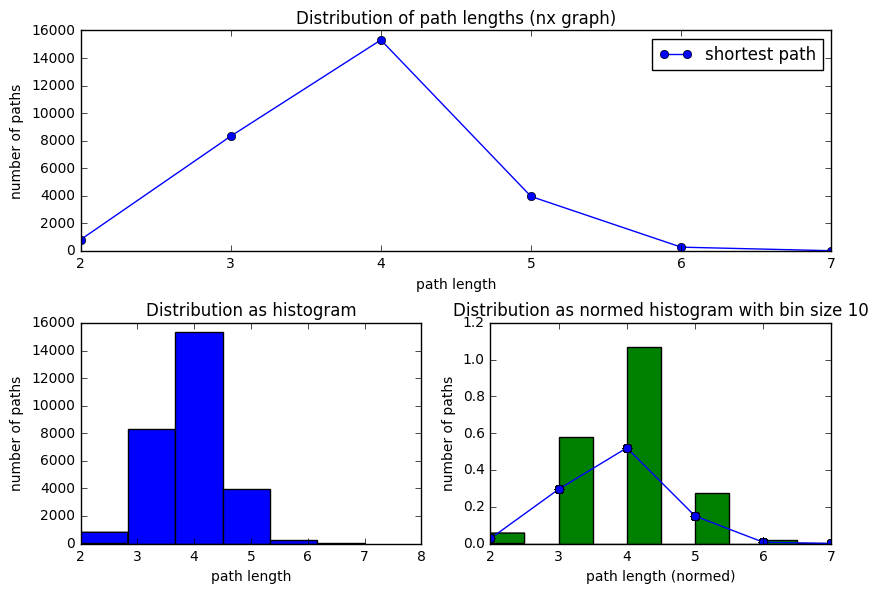

In [29]:
# plot the distribution
plot_distr_path(dat_nx, 'hist')

The differences to the teachers plot could come from the difference of using a directed or an undirected graph (directed graph has longer shortest paths). Another reason can also be keeping duplicates from `paths_finished.tsv` instead of looking at each node/link pair unique like above. Also note that there is no paths shorter than 2 (directly from source to target). Lastly the bin sizes can be different.

> * For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/human-path.png)

Counted shortest path lengths Counter({5.0: 5789, 4.0: 5481, 6.0: 5081, 7.0: 3565, 3.0: 2406, 8.0: 2183, 9.0: 1342, 10.0: 772, 2.0: 516, 11.0: 492, 12.0: 262, 13.0: 202, 14.0: 151, 15.0: 112, 16.0: 72, 17.0: 54, 18.0: 43, 19.0: 33, 20.0: 27, 23.0: 20, 21.0: 16, 22.0: 15, 25.0: 14, 24.0: 10, 26.0: 5, 28.0: 5, 31.0: 5, 27.0: 4, 29.0: 4, 33.0: 4, 38.0: 3, 30.0: 2, 32.0: 2, 35.0: 2, 36.0: 2, 40.0: 2, 37.0: 1, 42.0: 1, 43.0: 1, 45.0: 1, 46.0: 1, 54.0: 1, 55.0: 1, 91.0: 1})


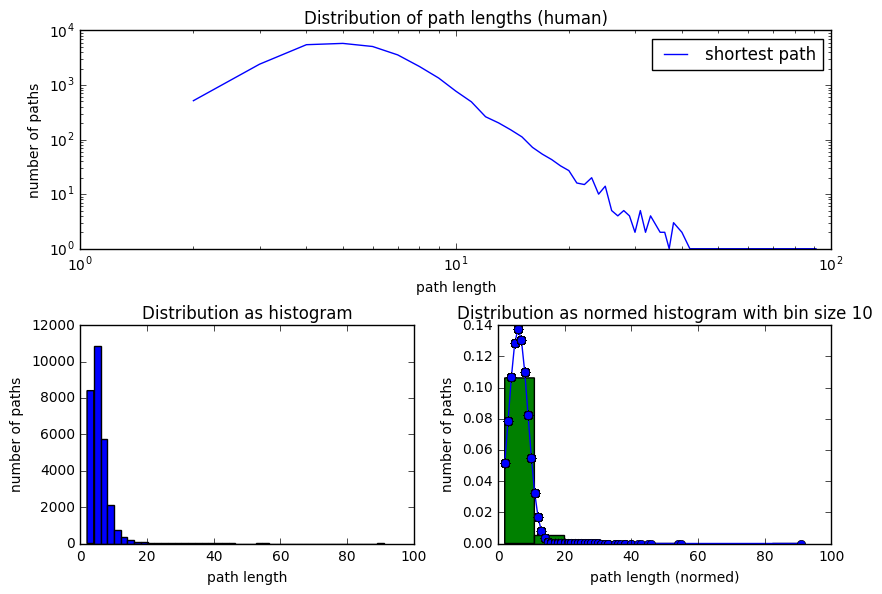

In [35]:
dat_human = list()
for p in p_compare:
    sh_p_list = p_compare[p]['human_shortest_path']
    # take the average to have one value
    avg = sum(sh_p_list) / len(sh_p_list)
    # save in the dict
    p_compare[p]['human_shortest_path_avg'] = avg
    # values are rounded to reduce bin size
    dat_human.append(round(avg))
    
plot_distr_path(dat_human, 'loglog')

I did not incorporate the back button as a visited node because it is not represented as a node in the graph either. Maybe it was even accidentally caused. Since human paths can occur many times the average was calculated for all unique source/target pairs.

> * How much longer are the human paths on average?


Note that this number can vary from your results since not every single human path goes into the calculation but the average of all human paths for one unique source/target pair. Rounding the average like in the graph is not necessary since we don't depend on a bin size.

In [33]:
avg_longer = list()
for p in p_compare:
    human = p_compare[p]['human_shortest_path_avg']
    nx_graph = p_compare[p]['nx_shortest_path']

    # how much longer value can only get 0 since nx_graph definetly has the shortest path
    val = human - nx_graph
    avg_longer.append(val)
    
# display average
print "Human paths are on average", sum(avg_longer) / len(avg_longer), "clicks longer than the actual shortest path."

Human paths are on average 2.20737525499 clicks longer than the actual shortest path.


> * Create scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.

Graph y-axis starts at 2 because that's the minimum shortest path.

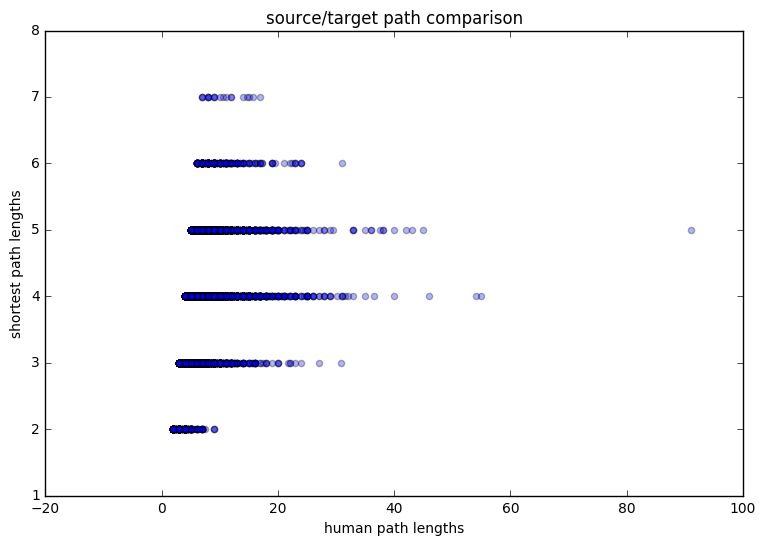

In [22]:
# add data
x, y = list(), list()
for p in p_compare:
    sh_p_human_list = p_compare[p]['human_shortest_path']
    x.append(sum(sh_p_human_list) / len(sh_p_human_list))
    y.append(p_compare[p]['nx_shortest_path'])

# draw plot
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.scatter(x, y, alpha=0.3)
ax.set_xlabel('human path lengths')
ax.set_ylabel('shortest path lengths')
plt.title('source/target path comparison')
plt.show()

> * Is there a correlation between human/shortest path-lengths? What is the correlation.

When the link is on the same page (length 1) it is mostly found by humans. Also for 2 links in between pages (nodes) they are fairly close together until the spread becomes much greater for 3 to 7 links.

# Betweenness

An interesting definition of centrality is _betweenness centrality_ (here's a handy [link to the NetworkX documentation](http://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html)). In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.


In this part, we will create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a nodes's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all naviagtion paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

In the exercises below, we investigate the relationship between navigation centrality and betweenness centrality.

*Exercises*

> Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset.
> Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.

In [36]:
bet_cent_dict = nx.betweenness_centrality(w_graph)

In [37]:
def navigation_centrality(nodes, nav_paths, len_path_list):
    # how often is each node in the list
    cnt_nodes = Counter(nav_paths)
    
    # run through the list of nodes
    nav_cent = dict()
    for i in nodes:
        # define as zero
        nav_cent[i] = 0
        # number of times i is in navigation paths
        if cnt_nodes[i] != 0:
            # take fraction of all navigation paths
            nav_cent[i] = cnt_nodes[i] / len_path_list
    return nav_cent

In [38]:
# create a list of all navigation paths
nav_paths = list()
len_path_list = 0
for path in path_list:
    n = path.split(';')
    # exclude back links and source/target from the count
    nodes_path = [x for x in n[1:-1] if x != '<']
    # if there is nodes in between source and target
    if nodes_path:
        len_path_list += 1
        # concatenate to main list
        nav_paths += nodes_path

In [39]:
# build the dict containing key: node and value: navigation centrality
nav_cent_dict = navigation_centrality(w_graph.nodes(), nav_paths, len_path_list)

In [40]:
for key in sorted(bet_cent_dict)[:10]:
    print key, bet_cent_dict[key]

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in 0.0
%C3%85land 0.0
%C3%89douard_Manet 0.0
%C3%89ire 0.0
%C3%93engus_I_of_the_Picts 0.0
%E2%82%AC2_commemorative_coins 0.0
10th_century 0.00052638082373
11th_century 0.000628076444177
12th_century 0.00133960639219
13th_century 0.000806657935376


In [45]:
for key in sorted(nav_cent_dict)[:10]:
    print key, nav_cent_dict[key]

%C3%81ed%C3%A1n_mac_Gabr%C3%A1in 0
%C3%85land 3.95969035221e-05
%C3%89douard_Manet 3.95969035221e-05
%C3%89ire 5.93953552832e-05
%C3%93engus_I_of_the_Picts 0
%E2%82%AC2_commemorative_coins 0
10th_century 0.00182145756202
11th_century 0.00186105446554
12th_century 0.0021382327902
13th_century 0.00192044982082


> * First, list the 5 pages with highest navigation centrality.

In [31]:
# sort dict after value and display element 0 to 4
print sorted(nav_cent_dict.items(), key=lambda t: t[1], reverse=True)[0:5]

[('United_States', 0.17194746482715617), ('Europe', 0.08416150278654663), ('United_Kingdom', 0.07521727269184302), ('Earth', 0.06144043025838887), ('England', 0.06085584005612066)]


> * Second, list the 5 pages with highest betweenness centrality.

In [32]:
# sort dict after value and display element 0 to 4
print sorted(bet_cent_dict.items(), key=lambda t: t[1], reverse=True)[0:5]

[('United_States', 0.09360037318221956), ('United_Kingdom', 0.042163720769997685), ('England', 0.03223406679869201), ('Europe', 0.026851133195243022), ('Africa', 0.0240781266625001)]


> * Compare the two lists. Explain the differences between the two lists in your own words.

Betweenness centrality of a node $i$ is the sum of the fraction of all-pairs shortest paths that pass through $i$. On the contrary navigation centrality takes the human paths instead of the shortest paths. The more people go through one site to get to the target the higher the navigation centrality much like the betweenness centrality.

The main difference between the two dictionaries is that some people often go through a site where they think to find a link. Thus other wikipedia pages get a higher centrality compared to the actual flow that would be taken in the graph. Although the to entries are similar the values for navigation centrality are generally higher.

> * Create a scatterplot of betweenness centrality vs. navigation centrality.

In [65]:
# scatter plot for centrality comparison
def scatter_nav_bet(x_bet, y_nav):
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    ax.scatter(x_bet, y_nav, alpha=0.3)
    ax.set_xlabel('betweenness centrality')
    ax.set_ylabel('navigation centrality')
    plt.axis([
            min(x_bet)-(max(x_bet)*0.05), 
            max(x_bet)+(max(x_bet)*0.05), 
            min(y_nav)-(max(y_nav)*0.05), 
            max(y_nav)+(max(y_nav)*0.05)])
    plt.title('centrality comparison')

    # plot linear regression line
    axes = plt.gca()
    x_plot = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_bet, y_nav)
    y_plot = slope * x_plot + intercept
    plt.plot(x_plot, y_plot, color='red')

    plt.show()

    print "Correlation coefficient between betweenness centrality and navigation centrality =", np.corrcoef(
        x=x_bet, y=y_nav)[0,1]

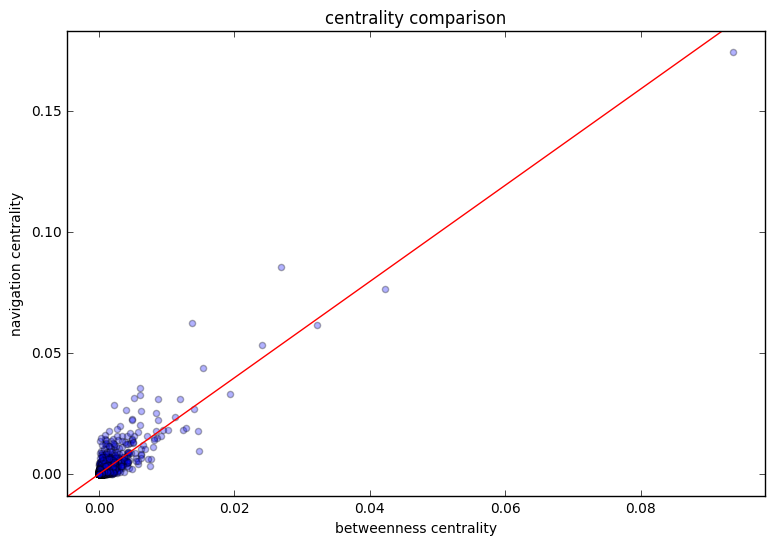

Correlation coefficient between betweenness centrality and navigation centrality = 0.913376965894


In [66]:
# add data betweenness centrality vs. navigation centrality in right order
x_bet, y_nav = list(), list()
for k, v in bet_cent_dict.iteritems():
    x_bet.append(v)
    y_nav.append(nav_cent_dict[k])

# draw plot
scatter_nav_bet(x_bet, y_nav)

> * Let's explore the pages that have navigation centrality equal to zero.
>   * How many pages have zero navigation centrality?

In [57]:
print "Number of pages with zero navigation centrality =", len([cent for cent in nav_cent_dict.values() if cent == 0])

Number of pages with zero navigation centrality = 1198


>   * What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).

In [58]:
highest_b_cent = 0
page_with_highest_cent = None
for key, cent in nav_cent_dict.iteritems():
    # has zero navigation centrality
    if cent == 0:
        # compare to previous highest value
        if bet_cent_dict[key] > highest_b_cent:
            highest_b_cent = bet_cent_dict[key]
            page_with_highest_cent = key

print 'Page with zero navigation centrality ({0}) and highest betweenness centrality ({1}) is {2}'.format(
    nav_cent_dict[page_with_highest_cent], bet_cent_dict[page_with_highest_cent], page_with_highest_cent)

Page with zero navigation centrality (0) and highest betweenness centrality (0.00111830217085) is TGV


In [59]:
# looking at the degree of node TGV
print "degree for node TGV:", w_graph.degree('TGV')

degree_sequence = sorted(nx.degree(w_graph).values(),reverse=True) # degree sequence
d_max = max(degree_sequence)
d_min = min(degree_sequence)
print "maximum degree:", d_max, "and minimum degree:", d_min

degree for node TGV: 49
maximum degree: 1845 and minimum degree: 0


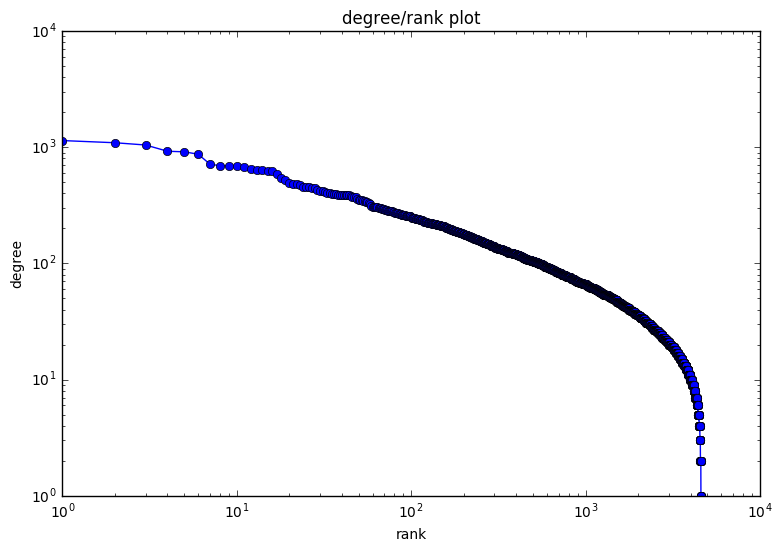

In [60]:
# drawing a degree ranked plot: 
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/degree_histogram.html
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.loglog(degree_sequence, 'b-', marker='o')
ax.set_xlabel('rank')
ax.set_ylabel('degree')
plt.title('degree/rank plot')
plt.show()

The [TGV](https://en.wikipedia.org/wiki/TGV) is the highspeed train in France. Especially the country pages (United_States, United_Kingdom, England, etc.) have a high centrality because they make a lot of references to people or other countries. The Wikipedia entry TGV also has references to countries/cities  or other known places that it passes (Channel Tunnel). This explains the non zero value for betweenness centrality. The page is rather central with 49 edges incident to this node. But for humans TGV is not a really common term since it is an abbreviation. Furthermore, no one would really expect to find country links under a subject about a train type. 

One plot below visualizes the subgraph of all connected nodes containing the TGV node. The second plot uses the shortest path to find all of the nodes reachable from the TGV node. To determine in- and out-edges the di-graph was converted to an undirected graph. In the second visualization it is however a directed graph that is drawn.

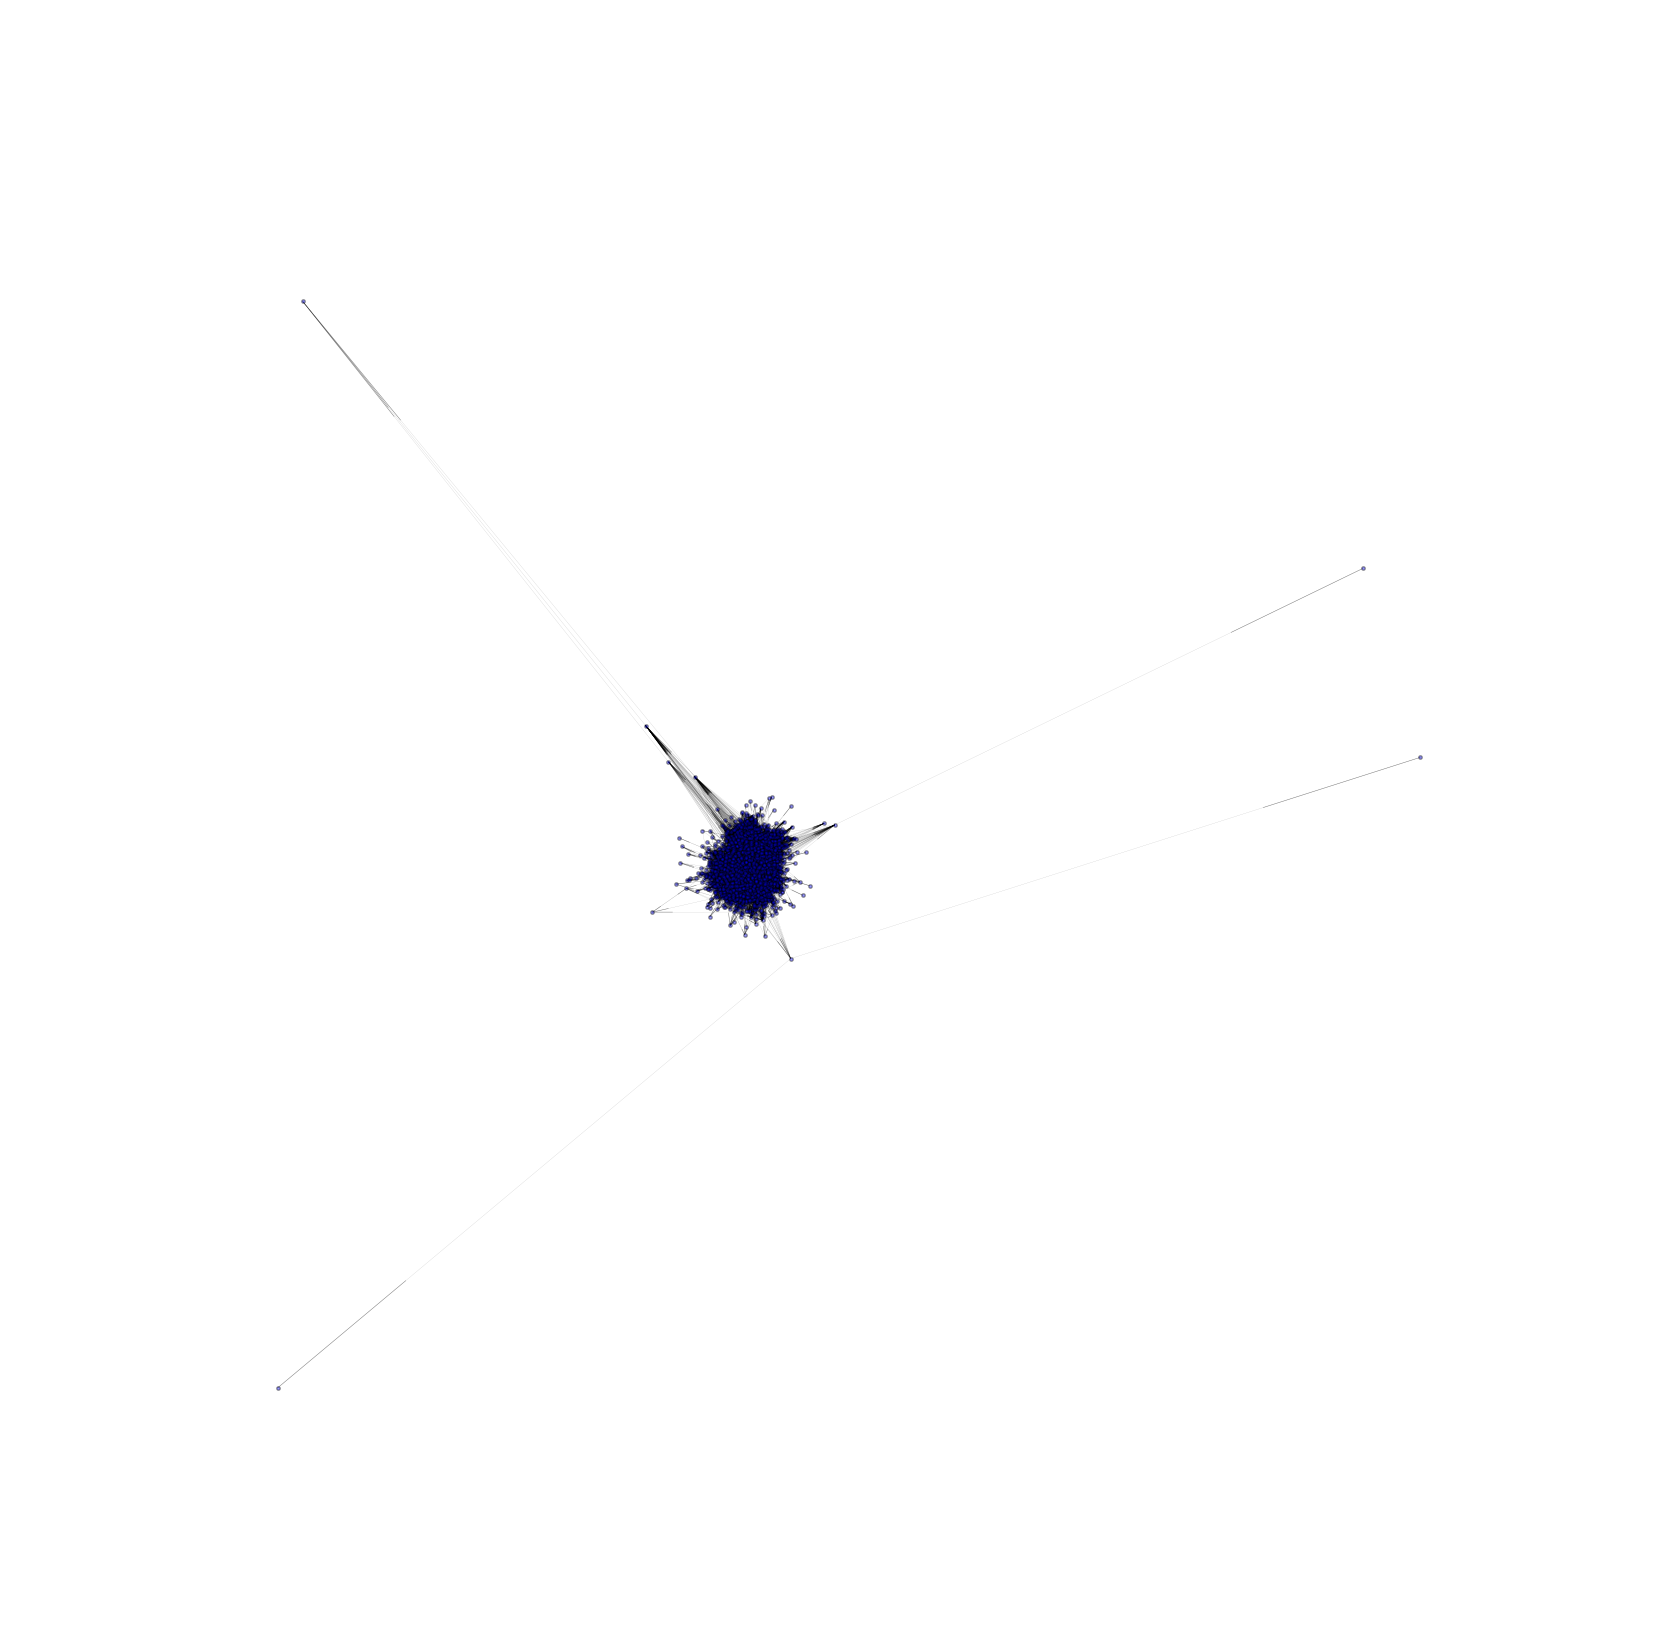

In [62]:
# TGV connected nodes reachable over shortest path 
s = w_graph.subgraph(nx.shortest_path(w_graph, 'TGV'))
plt.figure(num=None, figsize=(16, 16), dpi=1200)
nx.draw_spring(s, node_color='blue', with_labels=False, node_size=6, width=0.1, alpha=0.4)
plt.axis('off')
plt.show()

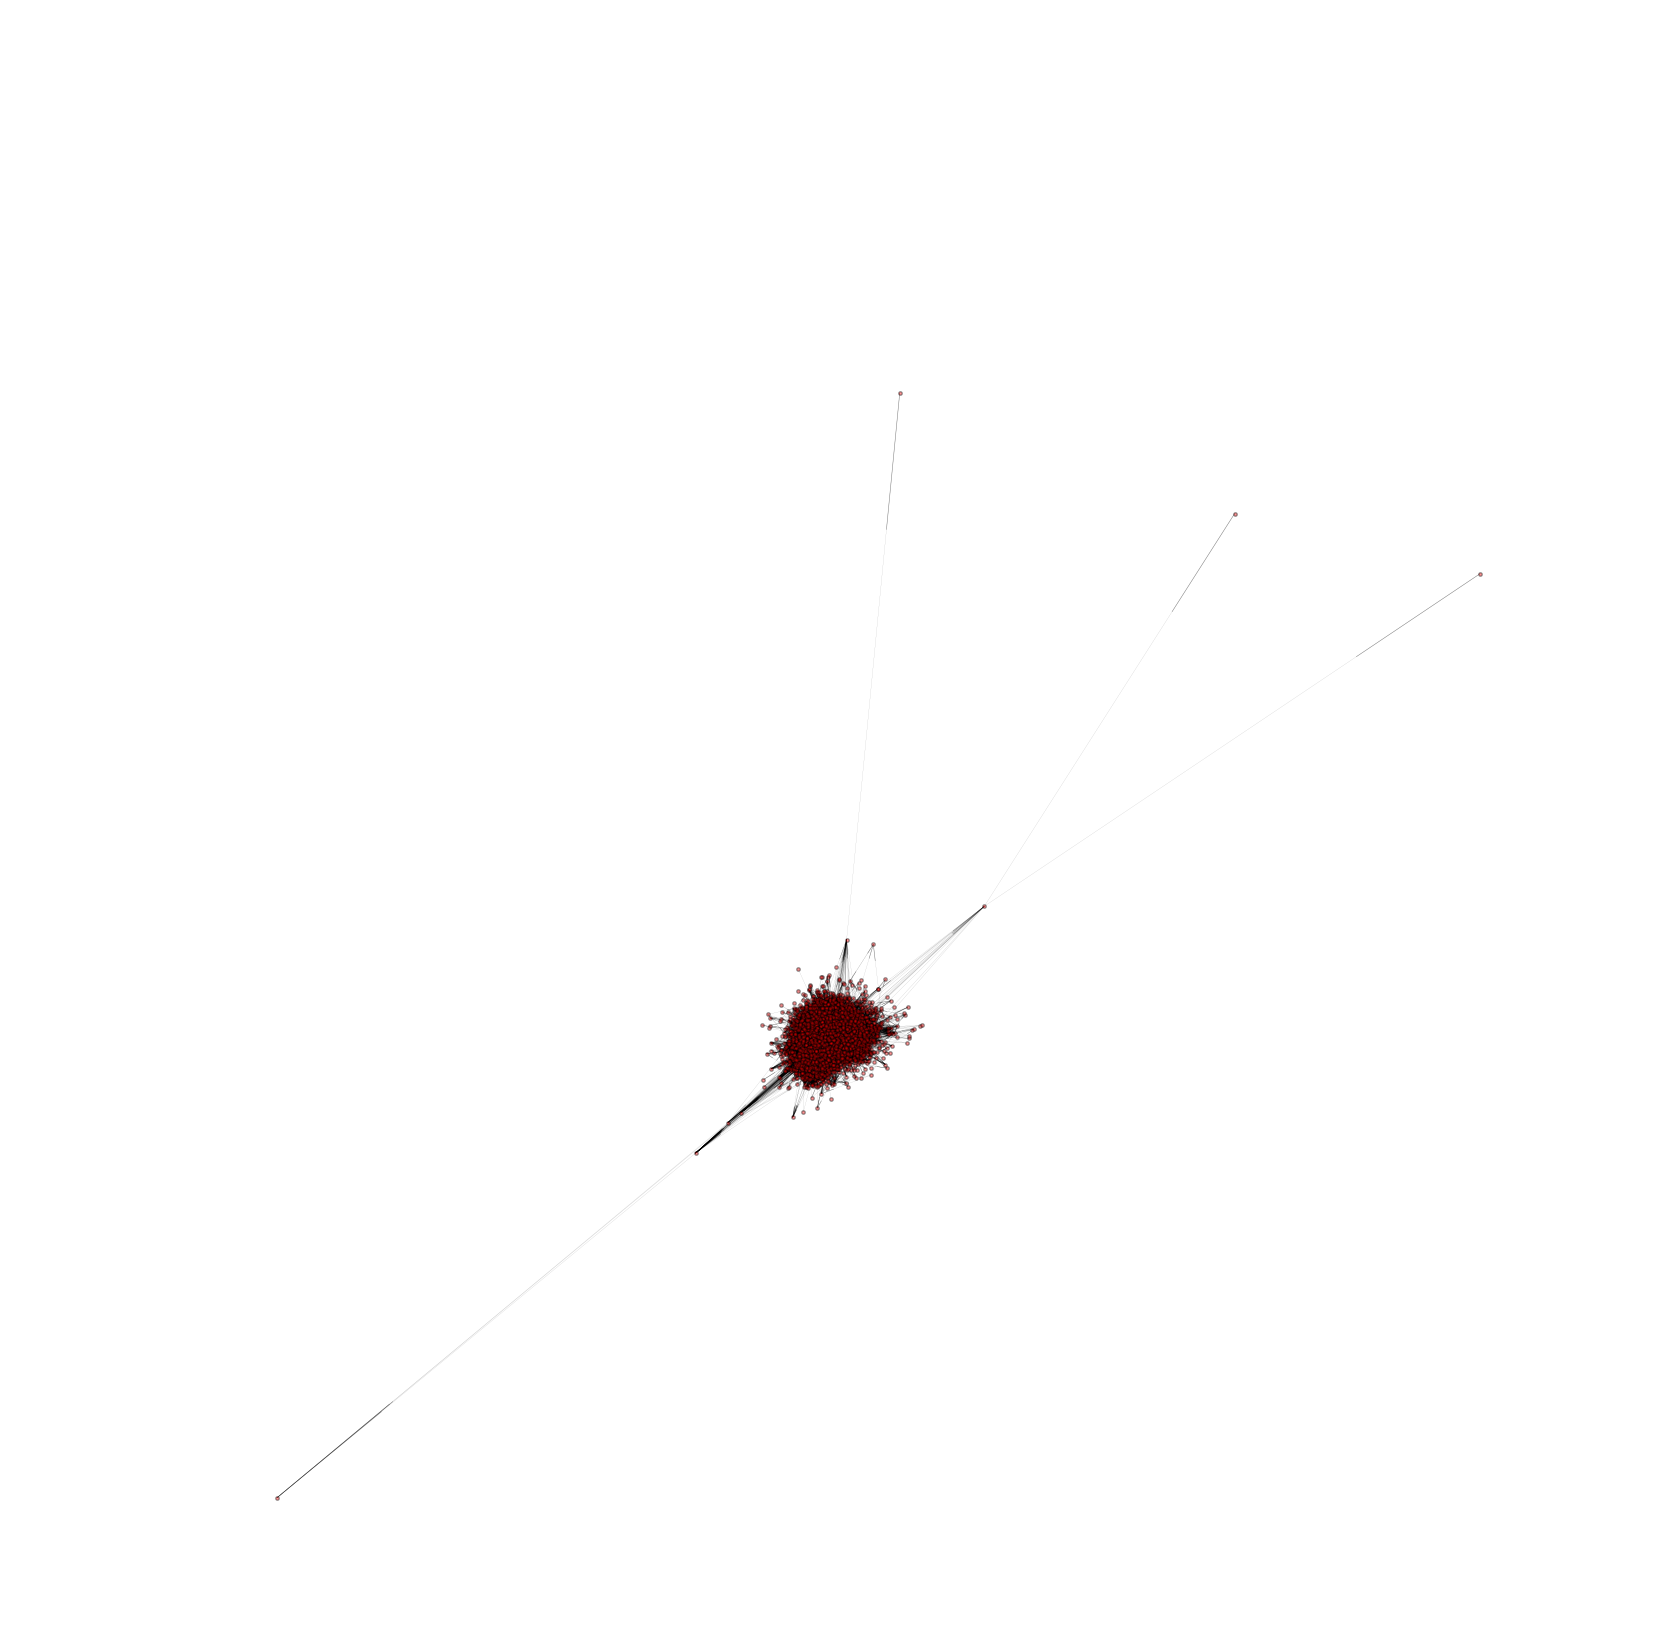

In [61]:
# TGV connected nodes subgraph drawing
pos = nx.spring_layout(w_graph)
# loop through the subgraphs until the target node is contained within the subgraph
for h in nx.weakly_connected_component_subgraphs(w_graph):
    if 'TGV' in h:
        plt.figure(num=None, figsize=(16, 16), dpi=1200)
        nx.draw(h, pos, node_color='red', node_size=6, width=0.1, alpha=0.4)
        plt.show()
        break

>   * Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/betweenness.png)

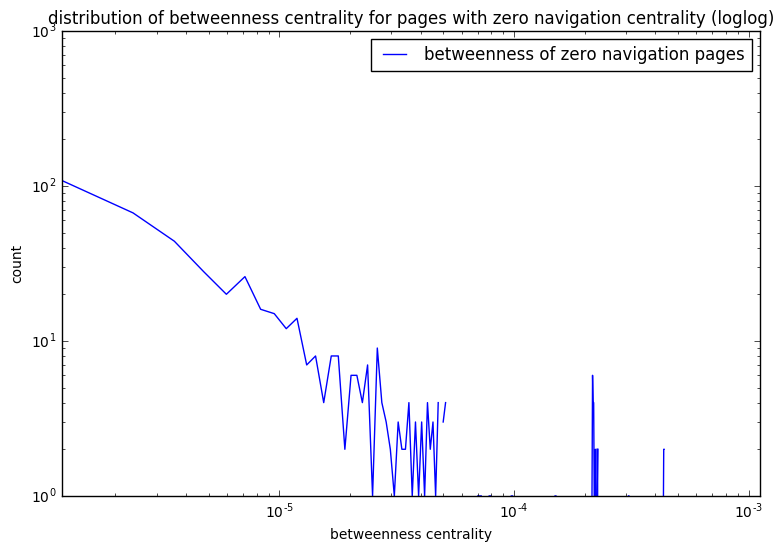

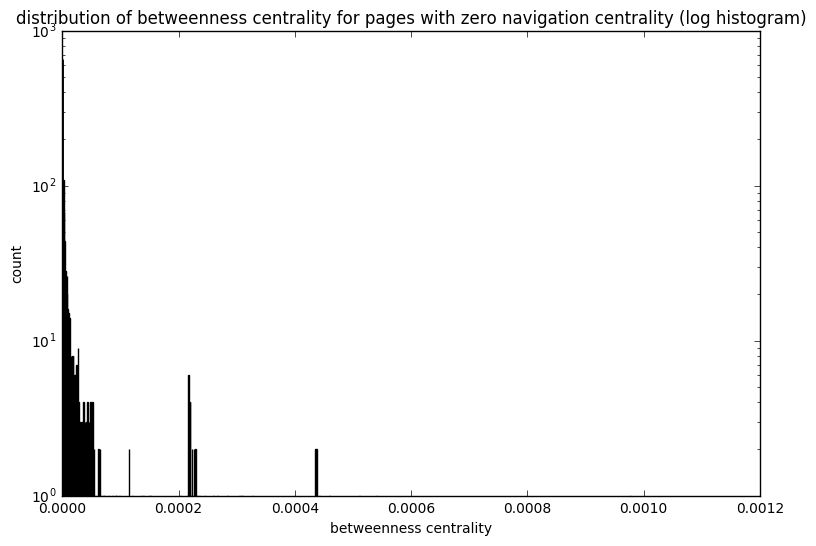

In [44]:
bet_cent_0_nav_cent = dict()
for key, cent in nav_cent_dict.iteritems():
    # has zero navigation centrality
    if cent == 0:
        bet_cent_0_nav_cent[key] = bet_cent_dict[key]

# put data into automatically sized bins
hist, bin_edges = np.histogram(bet_cent_0_nav_cent.values(), bins='auto')
# plot hist values on loglog scale
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
line = ax.loglog(bin_edges[:-1], hist, label='betweenness of zero navigation pages')
plt.legend(handles=line)
plt.xlim(min(bin_edges), max(bin_edges))
ax.set_xlabel('betweenness centrality')
ax.set_ylabel('count')
plt.title('distribution of betweenness centrality for pages with zero navigation centrality (loglog)')
plt.show()

# plt.hist bins='auto' passes directly to np.histogram
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.hist(bet_cent_0_nav_cent.values(), bins='auto', log=True)
ax.set_xlabel('betweenness centrality')
ax.set_ylabel('count')
plt.title('distribution of betweenness centrality for pages with zero navigation centrality (log histogram)')
plt.show()

> * Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.

In [69]:
# copy dict
nav_cent_no0 = nav_cent_dict.copy()
print "Before dictionary with navigation centrality has", len(nav_cent_no0), "elements."
# remove for every entry with zero value
for x in list(nav_cent_no0.keys()):
    if nav_cent_no0[x] == 0:
        del nav_cent_no0[x]

print "After removing entries with zero value,", len(nav_cent_no0), "elements remain."

Before dictionary with navigation centrality has 4604 elements.
After removing entries with zero value, 3406 elements remain.


In [71]:
# for comparison keep only nodes in navigation centrality dict without zero value entries
bet_cent_no0 = {k: bet_cent_dict[k] for k in nav_cent_no0.keys()}
print len(bet_cent_no0)

3406


  * What is the correlation between betweenness centrality and navigation centrality?

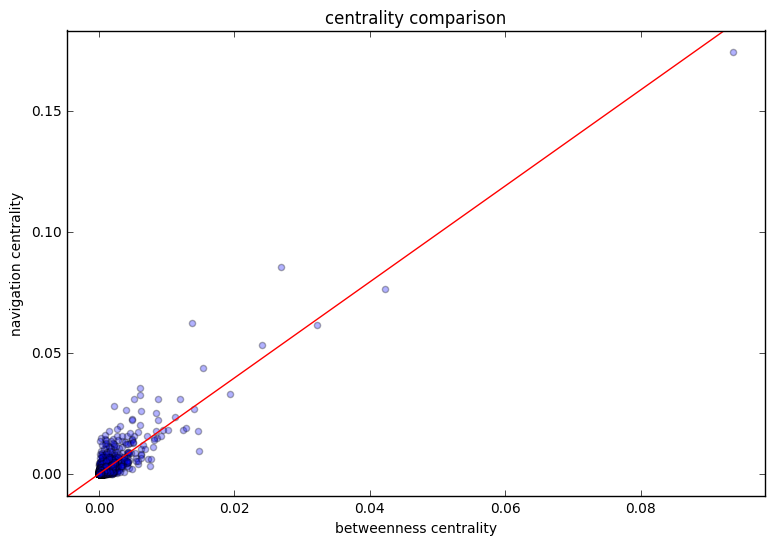

Correlation coefficient between betweenness centrality and navigation centrality = 0.912223234987


In [72]:
# add data betweenness centrality vs. navigation centrality
x_bet, y_nav = list(), list()
for k, v in bet_cent_no0.iteritems():
    x_bet.append(v)
    y_nav.append(nav_cent_no0[k])

scatter_nav_bet(x_bet, y_nav)

There is almost a linear correlation not much has changed in the coefficient after removing the zero elements since the values with zero navigation centrality also have a very small betweenness centrality.

>   * Comment on the top 5 outliers.

To find the outliers sort from highest to lowest x points (betweenness centrality) and then run through the lowest to highest y points (navigation centrality). Whenever both article keys match we can save the distance between the two. The points with the highest distance have the highest x and lowest y.

In [73]:
# data points of x and y
x_and_y = [(i, bet_cent_no0[i], nav_cent_no0[i]) for i in bet_cent_no0]  
# now sort after x descending
sorted_x = sorted(x_and_y, key=operator.itemgetter(1))[-15:]
# now sort all x top 20 after y ascending
sorted_y = sorted(sorted_x, key=operator.itemgetter(2))
# display articles top 5 outliers
print sorted_y[:5]

[('19th_century', 0.014746616150219532, 0.009859628977013998), ('London', 0.014598946145777923, 0.01775921122968184), ('Australia', 0.01246161945431006, 0.018511552396602585), ('Japan', 0.012905608235850973, 0.019362885822328695), ('India', 0.011197540562254329, 0.023520560692153875)]


These are the outliers that depend on how big the $n$ of the highest x values (betweenness centrality) is chosen. They are all countries, cities or a specific century that usually contains a lot of links to a lot of different topics. They are outliers because most human don't necessarily assume to find specific information on those pages (e.g.: and invention that is the target page and was invented in England). The outliers are usually very big pages like the 19th century where lots of links can be found. The outliers that are best visible in the chart correlate with the top 5 pages with highest navigation centrality. They actually have a much higher betweenness centrality because the humans have not chosen even more paths over this node, see below.

In [74]:
# show the items that lay over the imaginary line x/y (0.01, 0.01)
for k, v in nav_cent_no0.iteritems():
    if v > 0.01 and bet_cent_no0[k] > 0.01:
        # key, x and y
        print k, bet_cent_no0[k], v

World_War_II 0.0154188803721 0.0440515551684
India 0.0111975405623 0.0235205606922
United_Kingdom 0.04216372077 0.0764220237977
Australia 0.0124616194543 0.0185115523966
London 0.0145989461458 0.0177592112297
Europe 0.0268511331952 0.0855095131561
Africa 0.0240781266625 0.0533172305926
China 0.0102028015327 0.0184719554931
English_language 0.0139679853193 0.0269060959433
Japan 0.0129056082359 0.0193628858223
Germany 0.0193075253513 0.0331822051516
France 0.0119393880622 0.0311429646202
Earth 0.0137779020887 0.0624245184027
England 0.0322340667987 0.0618305648498
United_States 0.0936003731822 0.17470153834


# Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

*Exercises*

> First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now _characterize **each page** by a TF-IDF vector_ and not a group of pages.

In [76]:
### first clean each text
# tokenizer to remove punctuation and exclude numbers
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

# load english stop words
stopwords = nltk.corpus.stopwords.words('english')

# create a WordNetLemmatizer for stemming the tokens
wl = WordNetLemmatizer() 

wiki_cleaned = dict()
for art, t in wiki_plaintexts.iteritems():
     # create same structure for each article
    wiki_cleaned[art] = {
        'tf': dict(), 
        'idf': dict(),
        'tf-idf': dict(),
        'text': list()
    }    
    
    ### clean text
    # text string tokenized to list
    tokens = tokenizer.tokenize(t)
    # lemmatize, lower case, replace stopwords, only words with length > 2 and only alphabetic words
    wiki_cleaned[art]['text'] = [
        wl.lemmatize(w.lower()) for w in tokens
        if w.lower() not in stopwords and w.isalpha() and len(w) > 2]
    
print "Tokenized cleaned text in 14th_century:"
print wiki_cleaned['14th_century']['text']

Tokenized cleaned text in 14th_century:
['copyright', 'century', u'school', 'wikipedia', 'selection', 'related', u'subject', 'general', 'history', 'millennium', 'millennium', 'millennium', 'millennium', u'century', 'century', 'century', 'century', u'decade', 'century', 'statue', 'south', 'india', 'depicts', u'god', 'shiva', 'left', 'uma', 'right', 'housed', 'smithsonian', 'institution', 'washington', 'enlarge', 'century', 'statue', 'south', 'india', 'depicts', u'god', 'shiva', 'left', 'uma', 'right', 'housed', 'smithsonian', 'institution', 'washington', u'mean', 'recording', 'passage', 'time', 'century', 'century', 'lasted', u'event', 'transition', 'fom', 'medieval', 'warm', 'period', 'little', 'ice', 'age', 'beginning', 'ottoman', 'empire', 'early', 'expansion', u'balkan', 'avignon', 'papacy', u'transfer', 'seat', u'pope', 'italy', 'france', 'great', 'famine', u'kill', u'million', 'people', 'europe', 'forced', 'previous', u'location', 'aztec', 'found', 'city', 'tenochtitlan', 'vijayan

In [113]:
# compute the TF
for art, v in wiki_cleaned.iteritems():
    # compute number of times a word appears in a document
    wiki_cleaned[art]['w_freq'] = Counter(v['text'])
    wiki_cleaned[art]['w_set'] = set(v['text'])
    # get number of words in each document/branch
    wiki_cleaned[art]['w_len'] = len(v['text'])

    # compute TF for each token
    for token in wiki_cleaned[art]['w_set']:
        wiki_cleaned[art]['tf'][token] = wiki_cleaned[art]['w_freq'][token] / wiki_cleaned[art]['w_len']

print "Top 10 words in 14th_century after term frequency:"
print sorted(wiki_cleaned['14th_century']['tf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]

Top 10 words in 14th_century after term frequency:
[('century', 0.024630541871921183), ('england', 0.014778325123152709), ('poet', 0.014778325123152709), ('empire', 0.012315270935960592), ('wikipedia', 0.009852216748768473), (u'year', 0.009852216748768473), ('millennium', 0.009852216748768473), ('beginning', 0.009852216748768473), ('great', 0.009852216748768473), ('english', 0.009852216748768473)]


The computed term frequency is the number of times a term (= word) occurs in a document. A higher weight (more importance) is put on a word that occurs frequently.

In [84]:
# compute number of documents containing a particular word
num_docs_containing = Counter()
for art in wiki_cleaned:
    for token in wiki_cleaned[art]['w_set']:
        # increase the count for each word
        num_docs_containing[token] += 1

# examples of a common word and a not so common one
print "docs containing work vs. homomorphism:", num_docs_containing['work'], "to", num_docs_containing['homomorphism']

# compute IDF
total_docs = len(wiki_cleaned.keys())
for art in wiki_cleaned: 
    for token in wiki_cleaned[art]['w_set']:        
        # the Inverse-Document-Frequency
        wiki_cleaned[art]['idf'][token] = math.log(
            total_docs / num_docs_containing[token])

print "\nTop 10 words in 14th_century after inverse document frequency:"
print sorted(wiki_cleaned['14th_century']['idf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]

docs containing work vs. homomorphism: 2495 to 1

Top 10 words in 14th_century after inverse document frequency:
[('uncemented', 8.4346807698417727), ('lollardy', 7.7415335892818282), ('mansa', 7.7415335892818282), ('harihara', 7.7415335892818282), ('krewo', 7.7415335892818282), ('penafiel', 7.7415335892818282), ('machaut', 7.7415335892818282), ('josaphat', 7.3360684811736636), ('tekrur', 7.3360684811736636), ('pizan', 7.0483864087218828)]


The computed inverse document frequency puts a weight on all terms depending on how often it appears in the whole document (all philosophy branches). Those words occurring very frequently in the document get a lower weight (e.g.: the) than terms that occur rarely (like proper nouns appearing in a single document/branch).

In [114]:
# compute IDF and TF-IDF
for art in wiki_cleaned:
    for token in wiki_cleaned[art]['w_set']:
        wiki_cleaned[art]['tf-idf'][token] = wiki_cleaned[art]['tf'][token] * wiki_cleaned[art]['idf'][token]
   
print "Top 10 words in 14th_century after tf-idf:"
print sorted(wiki_cleaned['14th_century']['tf-idf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]

Top 10 words in 14th_century after tf-idf:
[('alighieri', 0.042315004202509082), ('poet', 0.036981806636361025), ('josaphat', 0.036138268380165831), ('dante', 0.031949312110850704), ('uma', 0.029309232118491492), ('uffizi', 0.028914933065912495), ('petrarch', 0.028549869163677414), ('poland', 0.025027368823417957), ('shiva', 0.024633958450032648), ('millennium', 0.024602409505018196)]


TF-IDF is a simple weighting scheme to find important words within a category. These can be visualized in word or tag clouds where words with higher tf–idf value appear bigger and thus are more important in the document.

Inside the dictionary for each article the key `'tf-idf'` contains another dictionary containing a token and the corresponding tf-idf value. The article must be kept to determine it the tf-idf values to the nodes in the path.

> Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

In [202]:
# create a function to calculate the cosine similarity of two tf-idf dicts
def cosine_similarity(v1, v2):
    # take common keys from both vectors
    common_keys = set(v1).intersection(v2)
    # calculate dot product of common words
    dot_product = 0
    for key in common_keys:
        dot_product += v1[key] * v2[key]
    # calculate magnitude for full vectors
    magnitude = math.sqrt(
        sum([val ** 2 for val in v1.values()])) * math.sqrt(
        sum([val ** 2 for val in v2.values()]))
    if not magnitude:
        return 0
    return dot_product / magnitude

print "testing cosine similarity different vectors:"
print "same vectors", cosine_similarity({'yes': 2, 'no': 1}, {'yes': 2, 'no':1})
print "almost the same vectors", cosine_similarity({'yes': 2, 'maybe': 3, 'no': 1}, {'yes': 2, 'maybe': 3, 'no':2})
print "very different vectors", cosine_similarity({'yes': 40, 'maybe': 0, 'no': 10}, {'yes': 2, 'no': 30})

testing cosine similarity different vectors:
same vectors 1.0
almost the same vectors 0.972305585328
very different vectors 0.306531366089


In [172]:
# function to get a list of cosine similarities of a path with nodes
def cos_sim_path(nodes):
    cos_sim = list()
    # iterate pairwise from source to target: (S -> P1) (P1 -> P2) (P2 -> T)
    for i, n in enumerate(nodes):
        # break when target reached, i starts at 0
        if i+1 == len(nodes):
            break
        n1 = n
        n2 = nodes[i+1]
        # vector of corresponding node in path is taken
        words_n1 = wiki_cleaned[n1]['tf-idf']
        words_n2 = wiki_cleaned[n2]['tf-idf']
        # calculate product of frequencies for words that show up in both vectors
        cos_sim.append(
            cosine_similarity(words_n1, words_n2))
    # return average
    return sum(cos_sim) / len(cos_sim)

> Now you're ready for the exercises
> 
> * Calculate the average similarity for all human navigation paths (the _source_/_target_ pairs from above). Calculate mean/variance of these average similarities.
> * Calculate the average similarity for all shortest paths between the _source_/_target_ pairs. Calculate mean/variance of these average similarities.

In [173]:
# run through all human navigation paths, not just the shortest
avgs_human, avgs_nx = list(), list()
for path in path_list:
    # list of each node visited
    n = path.split(';')
    # elimate back choice as a visited node
    human_nodes = [x for x in n if x != '<']
    source = human_nodes[0]
    target = human_nodes[-1]
    
    # ignore paths with 2 or less nodes
    if not len(human_nodes) > 2:
        continue
    # get rid of wrong paths
    if source in isolated_nodes or target in isolated_nodes:
        continue

    # similarity from source to target
    h_cos_sim = cos_sim_path(human_nodes)
    nx_cos_sim = cos_sim_path(p_compare[(source, target)]['nx_shortest_nodes'])
    # save the average
    avgs_human.append(h_cos_sim)
    avgs_nx.append(nx_cos_sim)

In [178]:
h_arr = np.array(avgs_human)
print "Mean and variance for human path average similarity:", h_arr.mean(), h_arr.var()

nx_arr = np.array(avgs_nx)
print "Mean and variance for shortest path average similarity:", nx_arr.mean(), nx_arr.var()

Mean and variance for human path average similarity: 0.151013043586 0.00537519924072
Mean and variance for shortest path average similarity: 0.0820639041478 0.00355057755846


> * Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/path-similarity.png)

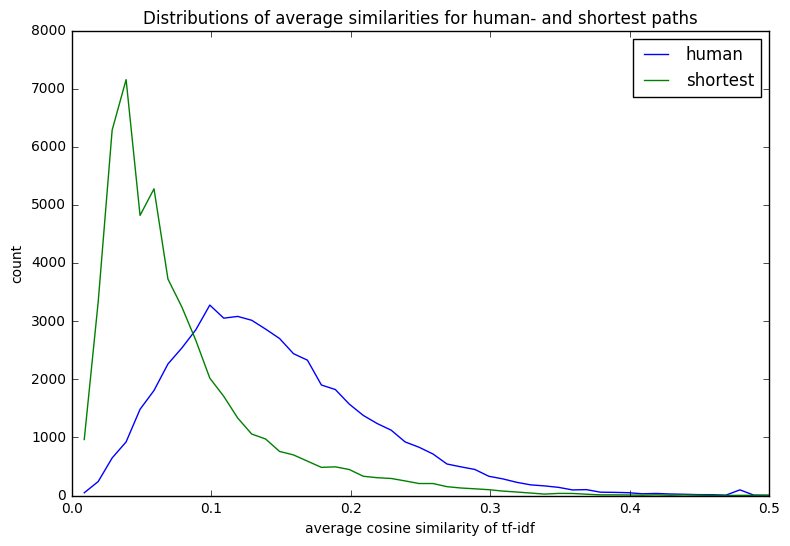

In [175]:
# put data into sized bins to generate distribution
binwidth = 0.01
hist_h, bin_edges_h = np.histogram(
    h_arr, 
    bins=np.arange(min(h_arr), max(h_arr) + binwidth, binwidth))
hist_nx, bin_edges_nx = np.histogram(
    nx_arr, 
    bins=np.arange(min(h_arr), max(h_arr) + binwidth, binwidth))

# plot hist values as line
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.plot(bin_edges_h[:-1], hist_h, label='human')
ax.plot(bin_edges_nx[:-1], hist_nx, label='shortest')
plt.legend()
ax.set_xlim([0, 0.5])
ax.set_ylabel('count')
ax.set_xlabel('average cosine similarity of tf-idf')
plt.title('Distributions of average similarities for human- and shortest paths')
plt.show()

> * Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.

In [196]:
cnt = Counter()
for idx, h_sim in enumerate(avgs_human):
    nx_sim = avgs_nx[idx]

    # check how often average similarity for human path is lower than shortest path
    cnt['total'] += 1
    # if cosine similarity is one then vectors are equal, thus lower value = less similarity
    if h_sim < nx_sim:
        cnt['h_less_similar'] += 1

In [197]:
print "The human-navigation average similarity is in {0} cases of the time (out of {1} valid paths)" \
    " lower in the case of human navigation.".format(cnt['h_less_similar'], cnt['total'])
print "That equals {0}%.".format((cnt['h_less_similar'] / cnt['total']) * 100)

The human-navigation average similarity is in 6597 cases of the time (out of 50509 valid paths) lower in the case of human navigation.
That equals 13.0610386268%.


> * Comment on your findings. Is **H1** true?

**H1:** Human navigation paths have more similar content than network shortest paths.

Yes **H1** is true. Only in 13% of the cases the shortest path had more similar content than the human path. The average cosine similarity shows humans tend to click more often through similar pages when navigating from source to target. A higher value for the average cosine similarity indicates more similarity with the maximum being one for totally identical vectors. According to the graph with the distribution of both similarities it can be seen that the peak for the shortest path's score comes much earlier and and has a much higher count compared to the human path.